In [208]:
from scipy.io import wavfile

(source_clean_fs, source_clean_data) = wavfile.read('./data/source_clean.wav')
(plini_clean_fs, plini_clean_data) = wavfile.read('./data/plini_clean.wav')
(source_noise_fs, source_noise_data) = wavfile.read('./data/source_noise.wav')
(plini_noise_fs, plini_noise_data) = wavfile.read('./data/plini_noise.wav')

In [209]:
import pandas as pd

In [210]:
source_clean_df = pd.DataFrame(source_clean_data, columns=['L', 'R'])
source_clean_df.head()

,L,R
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [211]:
plini_clean_df = pd.DataFrame(plini_clean_data, columns=['L', 'R'])
plini_clean_df.head()

,L,R
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [212]:
source_noise_df = pd.DataFrame(source_noise_data, columns=['L', 'R'])
source_noise_df.head()

,L,R
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [213]:
plini_noise_df = pd.DataFrame(plini_noise_data, columns=['L', 'R'])
plini_noise_df.head()

,L,R
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [216]:
plini_clean_df['L'].max(), plini_noise_df['L'].max()

(32767, 29669)

In [6]:
2 ** 15

32768

In [7]:
MAX_VALUE = 2 ** 15 - 1
MAX_VALUE

32767

In [8]:
len(plini_clean_df), len(source_clean_df)

(2442240, 2442240)

In [217]:
len(plini_noise_df), len(source_noise_df)

(814464, 814464)

In [218]:
CLEAN_START_END = int(len(plini_clean_df) * 0.8)
CLEAN_START_END

1953792

In [219]:
NOISE_START_END = int(len(plini_noise_df) * 0.8)
NOISE_START_END

651571

In [227]:
(X_train_c_start, X_train_c_end) = (0, CLEAN_START_END)
(X_test_c_start, X_test_c_end) = (CLEAN_START_END, len(source_clean_df))

In [228]:
(y_train_n_start, y_train_n_end) = (0, NOISE_START_END)
(y_test_n_start, y_test_n_end) = (NOISE_START_END, len(source_noise_df))

## IT'S MONO

In [229]:
X_train_c_raw = source_clean_df['L'][X_train_c_start:X_train_c_end]
X_train_c_raw.head()

0    0
1    0
2    0
3    0
4    0
Name: L, dtype: int16

In [13]:
X_test_raw = source_clean_df['L'][X_test_start:X_test_end]
X_test_raw.head()

1953792   -615
1953793   -560
1953794   -485
1953795   -395
1953796   -302
Name: L, dtype: int16

In [14]:
y_train_raw = plini_clean_df['L'][y_train_start:y_train_end]
y_train_raw.head()

0    0
1    0
2    0
3    0
4    0
Name: L, dtype: int16

In [15]:
y_test_raw = plini_clean_df['L'][y_test_start:y_test_end]
y_test_raw.head()

1953792    576
1953793    807
1953794    559
1953795    206
1953796    178
Name: L, dtype: int16

In [230]:
TR_C_N_DEV = source_clean_fs
TR_C_OFFSET_DEV = source_clean_fs * 2

TE_C_N_DEV = int(source_clean_fs / 8)
TE_C_OFFSET_DEV = source_clean_fs * 2

In [231]:
TR_N_N_DEV = source_noise_fs
TR_N_OFFSET_DEV = source_noise_fs * 2

TE_N_N_DEV = int(source_noise_fs / 8)
TE_N_OFFSET_DEV = source_noise_fs * 2

In [232]:
(TR_C_N_DEV, TE_C_N_DEV, TR_N_N_DEV, TE_N_N_DEV)

(44100, 5512, 44100, 5512)

In [109]:
# N_WINDOW_POINTS = int(source_clean_fs * 0.02)
N_WINDOW_POINTS = 32
N_WINDOW_POINTS

32

In [110]:
def make_windows(df, n_window_points):
    df_index = df.index
    index = 0
    windows = []

    for index in range(0, len(df) - n_window_points):
        windows.append(df_index[index:(index + n_window_points)])

    return windows

In [111]:
X_train_c_wnd = make_windows(X_train_c_raw[TR_OFFSET_DEV:TR_OFFSET_DEV+TR_N_DEV], N_WINDOW_POINTS)
len(X_train_wnd)

44068

In [112]:
X_test_wnd = make_windows(X_test_raw[TE_OFFSET_DEV:TE_OFFSET_DEV+TE_N_DEV], N_WINDOW_POINTS)
len(X_test_wnd)

5480

In [113]:
y_train_wnd = make_windows(y_train_raw[TR_OFFSET_DEV:TR_OFFSET_DEV+TR_N_DEV], N_WINDOW_POINTS)
len(y_train_wnd)

44068

In [114]:
y_test_wnd = make_windows(y_test_raw[TE_OFFSET_DEV:TE_OFFSET_DEV+TE_N_DEV], N_WINDOW_POINTS)
len(y_test_wnd)

5480

In [115]:
X_test_wnd[0]

RangeIndex(start=2041992, stop=2042024, step=1)

In [116]:
X_test_raw[X_test_wnd[0]]

2041992     153
2041993     147
2041994     154
2041995     176
2041996     215
2041997     279
2041998     358
2041999     443
2042000     539
2042001     625
2042002     696
2042003     755
2042004     791
2042005     801
2042006     790
2042007     755
2042008     691
2042009     598
2042010     478
2042011     333
2042012     169
2042013      -6
2042014    -183
2042015    -360
2042016    -528
2042017    -681
2042018    -813
2042019    -926
2042020   -1016
2042021   -1084
2042022   -1128
2042023   -1144
Name: L, dtype: int16

## Preparing data for processing

In [117]:
X_train = list(map(lambda wnd: X_train_raw[wnd], X_train_wnd))
X_train[0], X_train[1]

(88200    -725
 88201    -877
 88202    -986
 88203   -1013
 88204    -959
 88205    -815
 88206    -628
 88207    -424
 88208    -218
 88209     -28
 88210     151
 88211     303
 88212     431
 88213     534
 88214     615
 88215     671
 88216     707
 88217     751
 88218     842
 88219     990
 88220    1158
 88221    1316
 88222    1448
 88223    1559
 88224    1660
 88225    1754
 88226    1793
 88227    1738
 88228    1584
 88229    1357
 88230    1122
 88231     888
 Name: L, dtype: int16, 88201    -877
 88202    -986
 88203   -1013
 88204    -959
 88205    -815
 88206    -628
 88207    -424
 88208    -218
 88209     -28
 88210     151
 88211     303
 88212     431
 88213     534
 88214     615
 88215     671
 88216     707
 88217     751
 88218     842
 88219     990
 88220    1158
 88221    1316
 88222    1448
 88223    1559
 88224    1660
 88225    1754
 88226    1793
 88227    1738
 88228    1584
 88229    1357
 88230    1122
 88231     888
 88232     649
 Name: L, dtype: 

In [118]:
X_test = list(map(lambda wnd: X_test_raw[wnd], X_test_wnd))
X_test[0], X_test[1]

(2041992     153
 2041993     147
 2041994     154
 2041995     176
 2041996     215
 2041997     279
 2041998     358
 2041999     443
 2042000     539
 2042001     625
 2042002     696
 2042003     755
 2042004     791
 2042005     801
 2042006     790
 2042007     755
 2042008     691
 2042009     598
 2042010     478
 2042011     333
 2042012     169
 2042013      -6
 2042014    -183
 2042015    -360
 2042016    -528
 2042017    -681
 2042018    -813
 2042019    -926
 2042020   -1016
 2042021   -1084
 2042022   -1128
 2042023   -1144
 Name: L, dtype: int16, 2041993     147
 2041994     154
 2041995     176
 2041996     215
 2041997     279
 2041998     358
 2041999     443
 2042000     539
 2042001     625
 2042002     696
 2042003     755
 2042004     791
 2042005     801
 2042006     790
 2042007     755
 2042008     691
 2042009     598
 2042010     478
 2042011     333
 2042012     169
 2042013      -6
 2042014    -183
 2042015    -360
 2042016    -528
 2042017    -681
 2042018

In [119]:
y_train = list(map(lambda wnd: y_train_raw[wnd], y_train_wnd))
y_train[0], y_train[1]

(88200    1118
 88201     258
 88202     145
 88203     854
 88204     896
 88205     -54
 88206   -1922
 88207   -3178
 88208   -1751
 88209    1715
 88210    4552
 88211    4313
 88212    2005
 88213    -137
 88214   -1049
 88215     866
 88216    3828
 88217    4486
 88218    2774
 88219      42
 88220   -1738
 88221   -1592
 88222     -35
 88223    1778
 88224    2595
 88225    1983
 88226    1740
 88227    1965
 88228    1299
 88229    1925
 88230    3392
 88231    4098
 Name: L, dtype: int16, 88201     258
 88202     145
 88203     854
 88204     896
 88205     -54
 88206   -1922
 88207   -3178
 88208   -1751
 88209    1715
 88210    4552
 88211    4313
 88212    2005
 88213    -137
 88214   -1049
 88215     866
 88216    3828
 88217    4486
 88218    2774
 88219      42
 88220   -1738
 88221   -1592
 88222     -35
 88223    1778
 88224    2595
 88225    1983
 88226    1740
 88227    1965
 88228    1299
 88229    1925
 88230    3392
 88231    4098
 88232    3392
 Name: L, dtype: 

In [120]:
y_test = list(map(lambda wnd: y_test_raw[wnd], y_test_wnd))
y_test[0], y_test[1]

(2041992    1572
 2041993     314
 2041994    -408
 2041995    -288
 2041996    -101
 2041997    -390
 2041998   -1198
 2041999   -2009
 2042000   -2520
 2042001   -2666
 2042002   -2592
 2042003   -2741
 2042004   -2906
 2042005   -2911
 2042006   -2718
 2042007   -2175
 2042008   -1581
 2042009   -1250
 2042010   -1388
 2042011   -1692
 2042012   -1780
 2042013   -1656
 2042014   -1289
 2042015    -987
 2042016    -755
 2042017    -609
 2042018    -437
 2042019    -199
 2042020     -61
 2042021      19
 2042022    -117
 2042023     -55
 Name: L, dtype: int16, 2041993     314
 2041994    -408
 2041995    -288
 2041996    -101
 2041997    -390
 2041998   -1198
 2041999   -2009
 2042000   -2520
 2042001   -2666
 2042002   -2592
 2042003   -2741
 2042004   -2906
 2042005   -2911
 2042006   -2718
 2042007   -2175
 2042008   -1581
 2042009   -1250
 2042010   -1388
 2042011   -1692
 2042012   -1780
 2042013   -1656
 2042014   -1289
 2042015    -987
 2042016    -755
 2042017    -609
 2042018

In [121]:
def normalize_keeping_mean(arr, forced_abs=None):
    left_abs = np.abs(arr.mean() - arr.min())
    right_abs = np.abs(arr.max() - arr.mean())
    
    n = max(left_abs, right_abs)
    
    if (forced_abs is not None):
        n = forced_abs
    
    return np.clip(arr / n, -1.0, 1.0)

In [122]:
def normalize(arr, forced_abs=None, mean=None):
    left_abs = np.abs(arr.mean() - arr.min())
    right_abs = np.abs(arr.max() - arr.mean())
    
    n = max(left_abs, right_abs)
    
    if (forced_abs is not None):
        n = forced_abs
        
    if (mean is None):
        mean = arr.mean()
    
    
    return np.clip((arr - mean) / n, -1.0, 1.0)

In [123]:
import numpy as np

X_tr = np.array(list(map(lambda x: np.array(x), X_train)))
X_tr_n = normalize(X_tr, forced_abs=MAX_VALUE, mean=0.0)
X_tr_n.min(), X_tr_n.max(), np.mean(X_tr_n)

(-0.07431257057405316, 0.09094515823847163, 4.246737367871073e-06)

In [124]:
X_te = np.array(list(map(lambda x: np.array(x), X_test)))
X_te_n = normalize_keeping_mean(X_te, forced_abs=MAX_VALUE)
X_te_n.min(), X_te_n.max(), np.mean(X_te_n)

(-0.05261391033661916, 0.04519791253395184, -6.593727939517224e-05)

In [125]:
y_tr = np.array(list(map(lambda x: np.array(x), y_train)))
y_tr_n = normalize_keeping_mean(y_tr, forced_abs=MAX_VALUE)
y_tr_n.min(), y_tr_n.max(), np.mean(y_tr_n)

(-0.401989806817835, 0.380596331675161, 5.842201732312055e-06)

In [126]:
y_te = np.array(list(map(lambda x: np.array(x), y_test)))
y_te_n = normalize_keeping_mean(y_te, forced_abs=MAX_VALUE)
y_te_n.min(), y_te_n.max(), np.mean(y_te_n)

(-0.16470839564195686, 0.1424604022339549, -0.00019012913060785963)

In [127]:
X_tr_n = X_tr_n.astype('float32')
X_te_n = X_te_n.astype('float32')
y_tr_n = y_tr_n.astype('float32')
y_te_n = y_te_n.astype('float32')

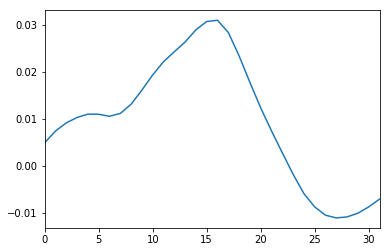

In [128]:
pd.Series(X_tr_n[100]).plot.line()

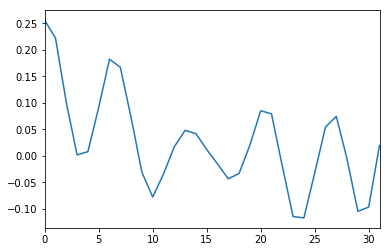

In [129]:
pd.Series(y_tr_n[100]).plot.line()

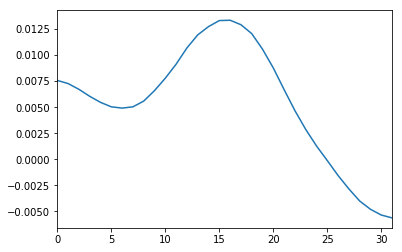

In [130]:
pd.Series(X_te_n[100]).plot.line()

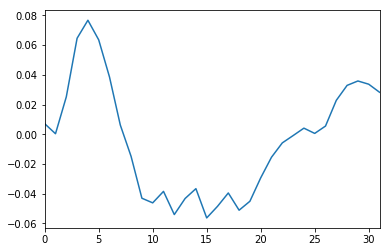

In [131]:
pd.Series(y_te_n[100]).plot.line()

## Need to apply FFT to data

The plan is to apply FFT, and take the freqs and amplitudes of first N peaks, feeding it into NN

In [132]:
test_wnd = X_te[0]
test_wnd

array([  153,   147,   154,   176,   215,   279,   358,   443,   539,
         625,   696,   755,   791,   801,   790,   755,   691,   598,
         478,   333,   169,    -6,  -183,  -360,  -528,  -681,  -813,
        -926, -1016, -1084, -1128, -1144], dtype=int16)

In [133]:
FD = 22050 * 2
FD

44100

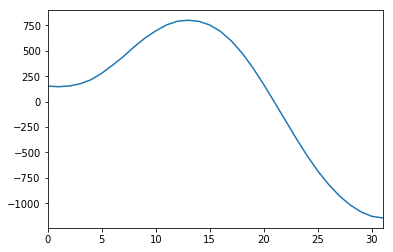

In [134]:
pd.Series(test_wnd).plot.line()

In [135]:
from numpy.fft import rfft, fftfreq, rfftfreq

freq = rfftfreq(32, 1./FD)
max_freq = freq[-1]

print(max_freq)

fft = rfft(test_wnd)

df = pd.Series(fft)

index = []

for i in range(0, len(fft)):
    index = index + [(i / len(fft)) * max_freq]

print(index)

df.index = index

22050.0
[0.0, 1297.0588235294117, 2594.1176470588234, 3891.1764705882356, 5188.235294117647, 6485.2941176470595, 7782.352941176471, 9079.411764705881, 10376.470588235294, 11673.529411764706, 12970.588235294119, 14267.64705882353, 15564.705882352942, 16861.764705882353, 18158.823529411762, 19455.882352941175, 20752.941176470587]


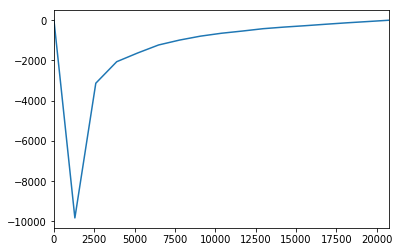

In [136]:
df.map(lambda x: x.imag).plot.line()

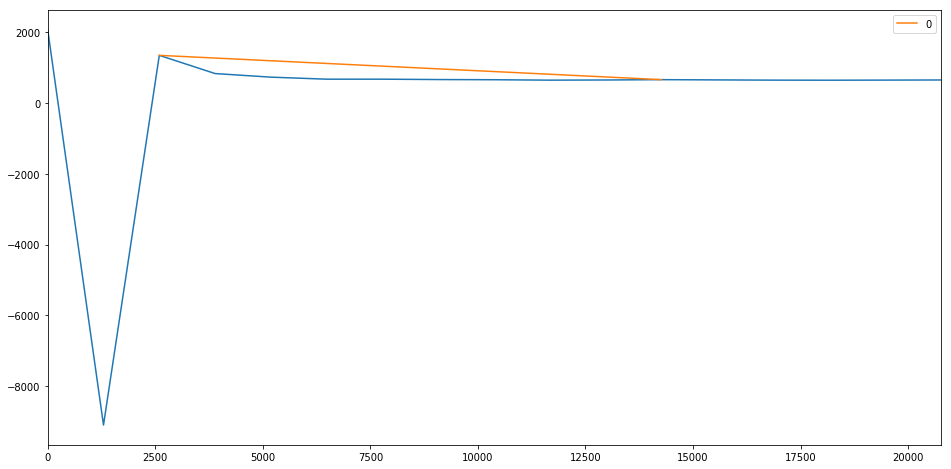

In [141]:
from scipy.signal import find_peaks
from matplotlib import pyplot as plt

(fig, ax) = plt.subplots(figsize=(16, 8))
df.plot.line(ax=ax)

peaks_re = find_peaks(df.map(lambda x: x.real))[0]
peaks_im = find_peaks(df.map(lambda x: x.imag))[0]

pd.DataFrame(df.iloc[peaks_re]).plot.line(ax=ax)

In [142]:
def append_peaks(df, peaks, N):
    res = df.iloc[peaks[:N]]

    for i in range(len(peaks), N_PEAKS):
        res = res.append(pd.Series([0], index=[0]))
        
    return res

In [143]:
peaks_re

array([ 2, 11])

In [144]:
N_PEAKS = 10

peaks_re = append_peaks(df, peaks_re, N_PEAKS)
peaks_im = append_peaks(df, peaks_im, N_PEAKS)

(peaks_re, peaks_im)

(2594.117647     (1351.2863121695095-3130.439869442133j)
 14267.647059    (664.2777190964798-339.66376228766103j)
 0.000000                                             0j
 0.000000                                             0j
 0.000000                                             0j
 0.000000                                             0j
 0.000000                                             0j
 0.000000                                             0j
 0.000000                                             0j
 0.000000                                             0j
 dtype: complex128, 0.0    0
 0.0    0
 0.0    0
 0.0    0
 0.0    0
 0.0    0
 0.0    0
 0.0    0
 0.0    0
 0.0    0
 dtype: int64)

In [145]:
from numpy.fft import rfft, fftfreq, rfftfreq
from scipy.signal import find_peaks
from matplotlib import pyplot as plt

MAGIC_NUMBER = 22050

def extract_fft_features(wnd, N_PEAKS):
    # Apply FFT
    
    freq = rfftfreq(N_WINDOW_POINTS, 1./FD)
    max_freq = freq[-1]

    fft = rfft(wnd)

    df = pd.Series(fft)

    index = []

    for i in range(0, len(fft)):
        index = index + [(i / len(fft))]

    df.index = index

    # Output FFT
    
    real = normalize(
         np.array(list(map(lambda x: x.real, df.values))),
         forced_abs=MAGIC_NUMBER,
         mean=0.0
    )
    
    imag = normalize(
        np.array(list(map(lambda x: x.imag, df.values))),
        forced_abs=MAGIC_NUMBER,
        mean=0.0
    )

    res = np.concatenate([real, imag])
    
    return res
    
    
    # Find peaks

#     peaks_re = find_peaks(df.map(lambda x: x.real))[0]
#     peaks_im = find_peaks(df.map(lambda x: x.imag))[0]

#     peaks_re = append_peaks(df, peaks_re, N_PEAKS)
#     peaks_im = append_peaks(df, peaks_im, N_PEAKS)
    
#     features_re = (
#          list(np.array(list(peaks_re.index))) +
#          list(normalize(np.array(list(map(lambda x: x.real, peaks_re.get_values()))), forced_abs=MAGIC_NUMBER, mean=0.0))
#     )
    
#     features_im = (
#          list(np.array(list(peaks_im.index))) +
#          list(normalize(np.array(list(map(lambda x: x.imag, peaks_im.get_values()))), forced_abs=MAGIC_NUMBER, mean=0.0))
#     )

#     return np.array(list(features_re) + list(features_im))

In [146]:
extract_fft_features(test_wnd, N_PEAKS)

array([ 0.09419501, -0.41276206,  0.06128283,  0.03794118,  0.03332838,
        0.03072445,  0.03072402,  0.03025742,  0.03002268,  0.02947596,
        0.02969528,  0.03012597,  0.02980087,  0.02950137,  0.02940898,
        0.02954296,  0.02970522,  0.        , -0.44566353, -0.14197006,
       -0.09345454, -0.07381607, -0.05575746, -0.0447379 , -0.03586779,
       -0.0293424 , -0.0243774 , -0.01903552, -0.01540425, -0.01231947,
       -0.00897093, -0.00579149, -0.00292255,  0.        ])

In [147]:
# it. fucking. works.
# Hail God.

In [148]:
def append_features(X):
    res = []
    
    for wnd in X:
        # res.append(np.array(list(wnd) + list(extract_fft_features(wnd, N_PEAKS))))
        res.append(extract_fft_features(wnd, N_PEAKS))
    
    return np.array(res)

In [149]:
append_features(X_tr_n[:1])

array([[ 2.31124079e-05, -8.70724610e-06, -5.34973644e-06,
        -1.38905736e-06, -1.20693343e-06, -7.96220556e-07,
        -7.69198091e-07, -1.00812972e-06, -9.95138740e-07,
        -1.00462925e-06, -9.80192200e-07, -9.91397334e-07,
        -9.79880484e-07, -9.77435380e-07, -9.83780079e-07,
        -9.81669296e-07, -9.81298104e-07,  0.00000000e+00,
         2.36763422e-05,  1.10765212e-05,  3.50252314e-06,
         2.48443201e-06,  1.35614401e-06,  1.50837174e-06,
         1.16921853e-06,  9.96522884e-07,  7.86358196e-07,
         6.53421786e-07,  5.25147813e-07,  3.88965763e-07,
         2.67475363e-07,  1.67764074e-07,  9.53220709e-08,
         0.00000000e+00]])

In [150]:
(len(X_tr), len(X_te), len(y_tr), len(y_te))

(44068, 5480, 44068, 5480)

In [151]:
%%time

# N_DEV_2 = 10000

X_tr_f = append_features(X_tr_n)
X_te_f = append_features(X_te_n)
y_tr_f = append_features(y_tr_n)
y_te_f = append_features(y_te_n)

CPU times: user 42.3 s, sys: 771 ms, total: 43 s
Wall time: 43.2 s


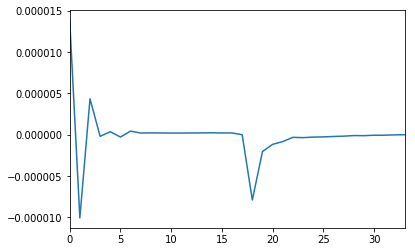

In [153]:
pd.Series(X_tr_f[100]).plot.line()

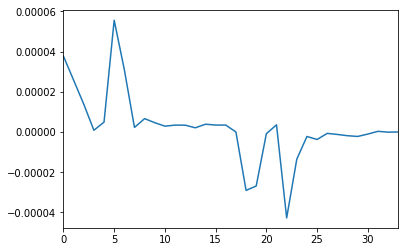

In [154]:
pd.Series(y_tr_f[100]).plot.line()

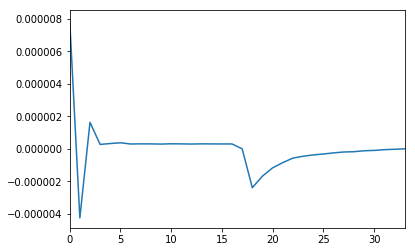

In [155]:
pd.Series(X_te_f[100]).plot.line()

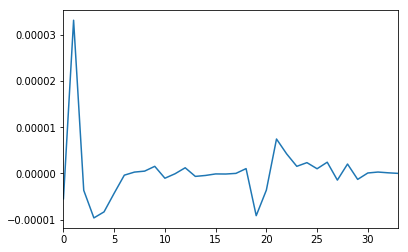

In [156]:
pd.Series(y_te_f[100]).plot.line()

In [157]:
(X_te_f[0], y_te_f[0])

(array([ 2.87469155e-06, -1.25968829e-05,  1.87026057e-06,  1.15790846e-06,
         1.01713262e-06,  9.37664275e-07,  9.37651206e-07,  9.23411224e-07,
         9.16247482e-07,  8.99562160e-07,  9.06255760e-07,  9.19399821e-07,
         9.09478127e-07,  9.00337857e-07,  8.97518335e-07,  9.01607202e-07,
         9.06558855e-07,  0.00000000e+00, -1.36009869e-05, -4.33271458e-06,
        -2.85209326e-06, -2.25275645e-06, -1.70163450e-06, -1.36533407e-06,
        -1.09463144e-06, -8.95486380e-07, -7.43961886e-07, -5.80935547e-07,
        -4.70114871e-07, -3.75972004e-07, -2.73779460e-07, -1.76747559e-07,
        -8.91919598e-08,  0.00000000e+00]),
 array([-5.20046476e-05,  2.77562079e-05,  9.41722492e-06, -3.93464272e-06,
         2.57669220e-06,  8.05041282e-08,  5.15301955e-06,  3.66225763e-06,
         2.78887987e-06,  2.38340065e-06,  2.15539692e-06,  1.74283601e-06,
         1.75264539e-06,  1.85690657e-06,  1.35571076e-06,  1.36404347e-06,
         1.40620455e-06,  0.00000000e+00,  1

In [158]:
# np.max(list(map(lambda row: row[65:], X_te_f)))
np.max(list(map(lambda row: row, X_te_f)))

4.0853281765162536e-05

In [159]:
# appending stats of the whole sample, fading from silence

In [160]:
train_shuffle_index = np.random.shuffle(np.arange(0, len(X_tr_f)))
test_shuffle_index = np.random.shuffle(np.arange(0, len(X_te_f)))

X_tr_f = X_tr_f[train_shuffle_index][0]
y_tr_f = y_tr_f[train_shuffle_index][0]

X_te_f = X_te_f[test_shuffle_index][0]
y_te_f = y_te_f[test_shuffle_index][0]

In [161]:
(len(X_tr_f[0]), X_tr_f[0])

(34, array([ 2.31124079e-05, -8.70724610e-06, -5.34973644e-06, -1.38905736e-06,
        -1.20693343e-06, -7.96220556e-07, -7.69198091e-07, -1.00812972e-06,
        -9.95138740e-07, -1.00462925e-06, -9.80192200e-07, -9.91397334e-07,
        -9.79880484e-07, -9.77435380e-07, -9.83780079e-07, -9.81669296e-07,
        -9.81298104e-07,  0.00000000e+00,  2.36763422e-05,  1.10765212e-05,
         3.50252314e-06,  2.48443201e-06,  1.35614401e-06,  1.50837174e-06,
         1.16921853e-06,  9.96522884e-07,  7.86358196e-07,  6.53421786e-07,
         5.25147813e-07,  3.88965763e-07,  2.67475363e-07,  1.67764074e-07,
         9.53220709e-08,  0.00000000e+00]))

In [163]:
N_FEATURES = 34
N_FEATURES

34

## Finished data processing!

## Moving on to training NN

In [164]:
import numpy as np

In [165]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils

In [235]:
y_tr_f.shape, X_tr_f.shape, X_te_f.shape, y_te_f.shape

((44068, 34), (44068, 34), (5480, 34), (5480, 34))

In [167]:
y_tr_f[0]

array([ 5.14468719e-05, -1.96906236e-06,  1.50280722e-05,  4.11279736e-06,
        9.19614837e-06, -2.28869611e-05,  1.11858489e-05,  1.26070353e-06,
       -1.86156025e-06, -4.64483437e-06, -1.64549327e-06, -2.32516035e-06,
        1.61512386e-08, -1.45144346e-06, -1.85877972e-06, -2.10244739e-06,
       -2.03871922e-06,  0.00000000e+00,  1.09030858e-05,  2.73374748e-05,
        6.18523765e-07, -2.38703769e-05,  3.70288534e-05,  3.90178061e-06,
        4.10504112e-06,  2.98126447e-06,  4.47397640e-06,  3.59611496e-07,
       -5.99699670e-07,  5.58272187e-07,  1.25593839e-07,  8.42064538e-07,
        2.86668160e-07,  0.00000000e+00])

In [170]:
model = Sequential()
model

In [171]:
model.add(Dense(65, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(171, activation='relu'))
model.add(Dense(327, activation='relu'))
model.add(Dense(171, activation='relu'))
model.add(Dense(65, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(N_FEATURES, activation=None))

In [172]:
# model.add(Dense(49, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(87, activation='relu'))
# model.add(Dense(49, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(N_FEATURES, activation='relu'))

In [173]:
model.compile(loss='mean_squared_error',
              optimizer='adam')

In [174]:
%%time

history = model.fit(X_tr_f, y_tr_f, batch_size=32, epochs=6, verbose=1)

Epoch 1/6
44068/44068 [==============================] - 3s 75us/step - loss: 1.6055e-09
Epoch 2/6
44068/44068 [==============================] - 3s 65us/step - loss: 8.9401e-10
Epoch 3/6
44068/44068 [==============================] - 3s 65us/step - loss: 8.9657e-10
Epoch 4/6
44068/44068 [==============================] - 3s 69us/step - loss: 8.9809e-10
Epoch 5/6
44068/44068 [==============================] - 3s 66us/step - loss: 9.2623e-10
Epoch 6/6
44068/44068 [==============================] - 3s 66us/step - loss: 9.1449e-10
CPU times: user 44.6 s, sys: 8.17 s, total: 52.8 s
Wall time: 18.4 s


In [175]:
score = model.evaluate(X_te_f, y_te_f, verbose=0)
score

1.0348142858422424e-09

In [73]:
1.0348142858422424e-09
1.2209316008848814e-09

0.017688618357486138

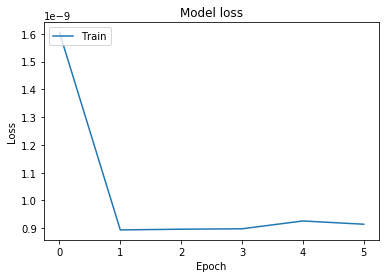

In [176]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [177]:
X_te_f[0]

array([ 2.87469155e-06, -1.25968829e-05,  1.87026057e-06,  1.15790846e-06,
        1.01713262e-06,  9.37664275e-07,  9.37651206e-07,  9.23411224e-07,
        9.16247482e-07,  8.99562160e-07,  9.06255760e-07,  9.19399821e-07,
        9.09478127e-07,  9.00337857e-07,  8.97518335e-07,  9.01607202e-07,
        9.06558855e-07,  0.00000000e+00, -1.36009869e-05, -4.33271458e-06,
       -2.85209326e-06, -2.25275645e-06, -1.70163450e-06, -1.36533407e-06,
       -1.09463144e-06, -8.95486380e-07, -7.43961886e-07, -5.80935547e-07,
       -4.70114871e-07, -3.75972004e-07, -2.73779460e-07, -1.76747559e-07,
       -8.91919598e-08,  0.00000000e+00])

In [178]:
def predict(model, row):
    return model.predict(np.array([row]))[0]

In [179]:
predict(model, X_te_f[0])

array([ 9.6908094e-05,  2.3934459e-05, -3.2686577e-05,  3.4690602e-05,
       -3.6481055e-05,  2.8634800e-05, -7.5039243e-06, -6.0128536e-05,
       -2.6554102e-05, -2.5344096e-05, -2.9796596e-05, -2.1390591e-05,
       -8.3411469e-06,  9.8328092e-06, -9.4340212e-06, -1.4496418e-05,
       -1.7734825e-05,  2.9646234e-08,  1.5994839e-05,  1.2008426e-05,
       -5.5620112e-06,  3.6597041e-05, -4.0778526e-05,  6.3555963e-06,
       -1.8846482e-05,  2.9717063e-05, -1.4787144e-05, -1.5826012e-05,
       -1.6747808e-05, -6.3662374e-05, -2.0128467e-05, -5.4723455e-07,
        1.5635433e-05,  6.7081942e-08], dtype=float32)

Text(0, 0.5, 'value')

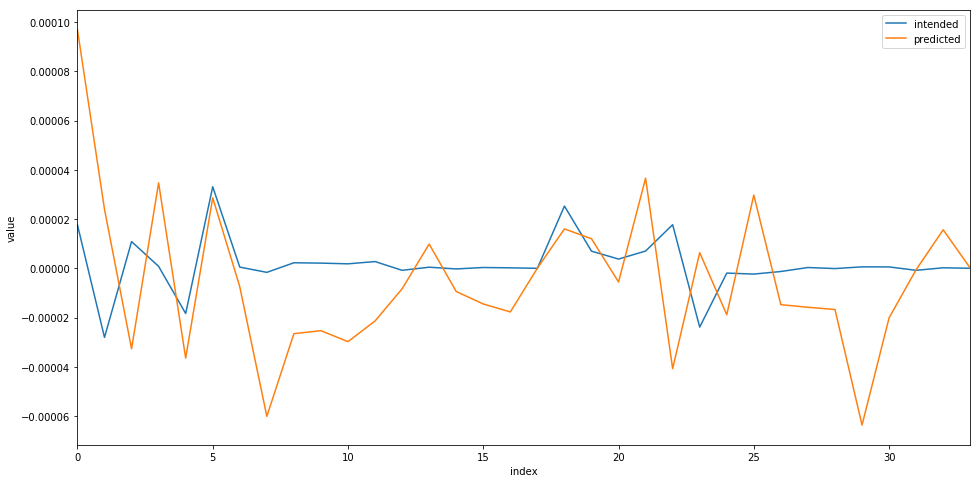

In [234]:
from scipy.signal import savgol_filter

(fig, ax) = plt.subplots(figsize=(16, 8))

I = 210

pd.Series(y_tr_f[I]).plot.line(ax=ax, label='intended')

pred = pd.Series(predict(model, X_tr_f[I]))

pred.plot.line(ax=ax, label='predicted')

# pd.Series(savgol_filter(pred, 5, 3)).plot.line(ax=ax, label='savgol(predicted)')

ax.legend(loc="upper right")
ax.set_xlabel('index')
ax.set_ylabel('value')

## Time to evaluate performance

In [79]:
# Til next time

In [80]:
def unpack_peaks(peaks, N):
    df = pd.Series()
    
    for i in range(0, N):
        df = df.append(pd.Series([peaks[N + i]], index=[peaks[i]]))
        
    return df

In [81]:
from numpy.fft import rfft, fftfreq, rfftfreq
from scipy.signal import find_peaks
from matplotlib import pyplot as plt

MAGIC_NUMBER = 22050

def unpack_fft_features(row, N_PEAKS):  
    # Unpack peaks
    
    features_re = row[:2*N_PEAKS]
    features_im = row[2*N_PEAKS:]
    
    df = pd.Series()
    
    peaks_re = unpack_peaks(features_re, N_PEAKS)
    peaks_im = unpack_peaks(features_im, N_PEAKS)
    
    peaks = (peaks_re * complex(1, 0)).add(peaks_im * complex(0, 1))
    
    print(peaks)
    
    return []






    # Apply IFFT
    
    freq = rfftfreq(N_WINDOW_POINTS, 1./FD)
    max_freq = freq[-1]

    fft = rfft(wnd)

    df = pd.Series(fft)

    index = []

    for i in range(0, len(fft)):
        index = index + [(i / len(fft))]

    df.index = index

    

In [82]:
I = 200

unpack_fft_features(predict(model, X_te_f[I]), N_PEAKS)

-0.000070    NaN
-0.000050    NaN
-0.000040    NaN
-0.000038    NaN
-0.000036    NaN
-0.000029    NaN
-0.000024    NaN
-0.000022    NaN
-0.000021    NaN
-0.000019    NaN
-0.000014    NaN
-0.000006    NaN
-0.000002    NaN
-0.000002    NaN
-0.000001    NaN
 0.000004    NaN
 0.000005    NaN
 0.000013    NaN
 0.000044    NaN
 0.000074    NaN
dtype: complex128


[]